<a href="https://colab.research.google.com/github/DmitryKutsev/DeepHW/blob/master/hw3_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install youtokentome

     |████████████████████████████████| 1.7MB 20.6MB/s 


In [2]:
!pip install alive-progress

In [3]:
# !wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
# !dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
# !apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
# !apt-get update
# !apt-get install cuda

In [4]:
# !pip install mxnet-cu92

In [5]:
import math
import numpy as np
import pandas as pd

import random
import json
import torch
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

from matplotlib import pyplot as plt

import youtokentome as yttm

In [6]:
print(torch.cuda.device_count())

1


In [7]:
print(torch.cuda.get_device_name(0))

Tesla T4


In [8]:
device = torch.device('cuda:0')

In [9]:
# !pip install --upgrade --force-reinstall -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# !unzip '/content/drive/My Drive/unsupervised.csv.zip'

In [12]:
!unzip '/content/drive/My Drive/qa_data.jsonl.zip'

Archive:  /content/drive/My Drive/qa_data.jsonl.zip
  inflating: qa_data.jsonl           
  inflating: __MACOSX/._qa_data.jsonl  


In [13]:
# questions = pd.read_csv('unsupervised.csv')
# questions.question = questions.question.map(lambda x: x.lower())

qa_data = list()

with open('qa_data.jsonl') as file_object:
    for line in file_object:
        qa_data.append(json.loads(line.strip()))
file_object.close()
qa_data = qa_data[:math.ceil(len(qa_data)*0.4)]#!!!!

In [14]:
with open('for_bpe.txt', 'w', encoding='utf-8') as f:
    for que in qa_data:
        f.write(que['question'] + '\n')
f.close()

vocab_size = 30_000
model_path = 'pretrained_bpe_lm.model'

In [15]:
%%time
# обучаем
# раскомментируйте этот код, чтобы обучить bpe
yttm.BPE.train(data='for_bpe.txt', vocab_size=vocab_size, model=model_path)

CPU times: user 9.45 s, sys: 1.06 s, total: 10.5 s
Wall time: 6.42 s


In [16]:
# загружаем токенизатор
tokenizer = yttm.BPE(model=model_path)

In [17]:
qa_data = qa_data[:math.ceil(len(qa_data)*0.6)]

In [31]:
tok_pairs = []
max_length = 32
for i in qa_data:
  
  tok_quest = tokenizer.encode(i['question'], eos=True)
  for resp in i['responses']:
    pair = (tok_quest, tokenizer.encode(resp, eos=True))
    # pair.append(tok_quest, tokenizer.encode(resp, bos=True, eos=True))
    tok_pairs.append(pair)


In [32]:
tok_pairs[9]

([572, 13653, 14803, 402, 3978, 392, 10868, 13775, 3],
 [364, 363, 2368, 4915, 434, 364, 438, 425, 15921, 506, 4118, 11565, 3])

In [33]:
qa_data[9]

{'category': 'Стиль, Мода, Звезды',
 'question': 'ну что за мода? не успел глотнуть кофе, уже потянулся за сигаретой!',
 'responses': ['не знаю милый, что за кайф! я сама мало курю, но когда напиюся тогда держись!;)))',
  'переходи на чай.',
  'я такой моды не знаю, потому что не курю',
  'а я вообще не курю и никогда не курила, но все равно не терплю, когда курят во время еды и в помещениях! фу!!!!',
  'скажу одно: курень вред. да и коффе неочень полезно']}

In [34]:
train_border = math.ceil(len(tok_pairs)*0.6)
test_border = math.ceil(len(qa_data)*0.8)

In [35]:
my_train = tok_pairs[:train_border]
my_test = tok_pairs[train_border:]

In [36]:
# train_df = pd.DataFrame(qa_data[:train_border])
# test_df = pd.DataFrame(qa_data[train_border:test_border])
# validation_df = pd.DataFrame(qa_data[test_border: ])

In [37]:
tokenizer.encode('аа памагити пожалст', bos=True, eos=True, output_type=yttm.OutputType.SUBWORD)

['<BOS>', '▁аа', '▁па', 'ма', 'ги', 'ти', '▁пожал', 'ст', '<EOS>']

In [38]:

batch_size = 64

max_len = 32 # это типа с запасом?

pad_index = 0
eos_index = 3

In [39]:
class LanguageModelData(torch.utils.data.Dataset):
    
    def __init__(self, data, max_len, pad_index, eos_index):
        
        self.data = data
        
        self.max_len = max_len
        
        self.pad_index = pad_index
        self.eos_index = eos_index
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        
        x = self.data[index][0][:self.max_len]
        y = self.data[index][1][:self.max_len]
        
        pads_x = [self.pad_index] * (self.max_len - len(x))
        pads_y = [self.pad_index] * (self.max_len - len(y))

        x = torch.tensor(x + pads_x).long()
        y = torch.tensor(y + pads_y).long()
        
        return x, y

In [40]:

torch.tensor([2] + [2, 3499, 392, 441, 14, 5232, 7788, 3]).long()

tensor([   2,    2, 3499,  392,  441,   14, 5232, 7788,    3])

In [41]:
# sent = tokenizer.encode('аа памагити пожалст', bos=True, eos=True)
# x = sent[:max_len]

# pads_x = [pad_index] * (max_len - len(x))
# x = torch.tensor([x + pads_x]).long()
# x = x.to(device)
# x
# with torch.no_grad():
#   pred = model(x)
# pred

In [42]:
train_dataset = LanguageModelData(data=my_train, max_len=max_len, 
                                  pad_index=pad_index, eos_index=eos_index)
validation_dataset = LanguageModelData(data=my_test, max_len=max_len,
                                       pad_index=pad_index, eos_index=eos_index)

len(train_dataset), len(validation_dataset)

(1119610, 746406)

In [43]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size)

In [44]:
for x, y in train_loader:
    break

In [45]:
len(validation_loader.dataset)

746406

In [46]:
x

tensor([[ 1678,   389,  5459,  ...,     0,     0,     0],
        [  424,   389, 16450,  ...,     0,     0,     0],
        [  361,   584,   464,  ...,     0,     0,     0],
        ...,
        [  826,  2191, 21124,  ...,     0,     0,     0],
        [  826,  2191, 21124,  ...,     0,     0,     0],
        [  826,  2191, 21124,  ...,     0,     0,     0]])

In [47]:
y

tensor([[ 3499,   392,   441,  ...,     0,     0,     0],
        [  424,   342,  4823,  ...,     0,     0,     0],
        [ 7534,   336, 19442,  ...,     0,     0,     0],
        ...,
        [  363,  1853,  3011,  ...,     0,     0,     0],
        [24624, 17689,   363,  ...,     0,     0,     0],
        [21124,  5742,  3011,  ...,     0,     0,     0]])

In [51]:
try:
  for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)
except Exception as e:
  pass

In [52]:
progress_bar = tqdm(total=len(validation_loader.dataset), desc='Testing')

for x, y in validation_loader:
    progress_bar.update(x.size(0))
progress_bar.close()

Testing: 100%|██████████| 746406/746406 [00:10<00:00, 68558.65it/s]


In [53]:
class LanguageModel(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, model_dim, num_layers,
                 padding_idx, dropout=0.35, weight_tying=True):
        
        super().__init__()
        
        self.embedding_layer = torch.nn.Embedding(num_embeddings=vocab_size,
                                                  embedding_dim=embedding_dim, padding_idx=padding_idx)
        
        self.embedding_dropout = SpatialDropout(p=dropout)
        
        self.lstm = torch.nn.LSTM(input_size=embedding_dim, hidden_size=model_dim, 
                                  num_layers=num_layers, dropout=dropout, batch_first=True)
        
        self.language_model_head = torch.nn.Linear(in_features=model_dim, out_features=vocab_size, bias=False)
        
        # как раз здесь задаем, чтобы веса входящего и выходящего слоя эмбеддингов шарились
        if weight_tying and embedding_dim == model_dim:
            self.language_model_head.weight = self.embedding_layer.weight
        
    def forward(self, x):
        
        x = self.embedding_layer(x)
        
        x = self.embedding_dropout(x)
        
        x, _ = self.lstm(x)
        
        x = self.language_model_head(x)
        
        return x

In [54]:
embedding_dim = 128
model_dim = 128
num_layers = 2
dropout = 0.35

In [57]:
class SpatialDropout(torch.nn.Dropout2d):
    
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p
    
    def forward(self, x):
        x = x.to(device)
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T)
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x

In [58]:
model = LanguageModel(vocab_size=vocab_size, embedding_dim=embedding_dim,
                      model_dim=model_dim, num_layers=num_layers,
                      dropout=dropout, padding_idx=pad_index)
model.to(device)

LanguageModel(
  (embedding_layer): Embedding(30000, 128, padding_idx=0)
  (embedding_dropout): SpatialDropout(p=0.35, inplace=False)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.35)
  (language_model_head): Linear(in_features=128, out_features=30000, bias=False)
)

In [59]:

# у нас есть тег eos (end of sentence), который есть в каждом тренировочном примере
# мы не будем считать лосс для падов
# вместо этого будем останавливать генерирование моделью в момент, когда она сгенерирует тег eos
# 
criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_index)
optimizer = torch.optim.Adam(params=model.parameters())

In [60]:

# функция для обучения одной эпохи
# почти все как всегда

def train(model, loader, criterion, optimizer, last_n_losses=500, verbose=True):
    
    losses = []

    progress_bar = tqdm(total=len(loader), disable=not verbose, desc='Train')

    model.train()

    for x, y in loader:

        x = x.to(device)
        y = y.to(device)

        pred = model(x)

        loss = criterion(pred.view(-1, pred.size(-1)), y.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        progress_bar.set_postfix(loss=np.mean(losses[-last_n_losses:]),
                                 perplexity=np.exp(np.mean(losses[-last_n_losses:])))

        progress_bar.update()

    progress_bar.close()
    
    return losses

In [61]:
epoch_losses = train(model, validation_loader, criterion, optimizer)

Train: 100%|██████████| 11663/11663 [05:39<00:00, 34.40it/s, loss=7.76, perplexity=2.33e+3]


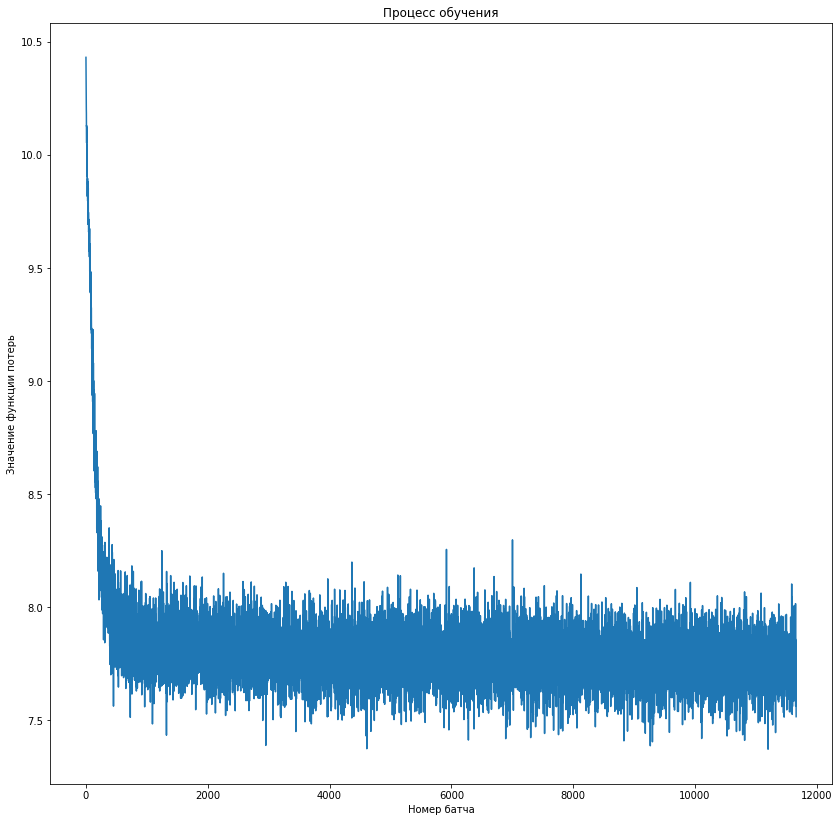

In [62]:

plt.figure(figsize=(14, 14))
plt.xlabel('Номер батча')
plt.ylabel('Значение функции потерь')
plt.title('Процесс обучения')
plt.plot(epoch_losses)

In [63]:
def evaluate(model, loader, criterion, last_n_losses=500, verbose=True):
    
    losses = []

    progress_bar = tqdm(total=len(loader), disable=not verbose, desc='Evaluate')

    model.eval()

    for x, y in loader:

        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():
            pred = model(x)

        loss = criterion(pred.view(-1, pred.size(-1)), y.view(-1))

        losses.append(loss.item())

        progress_bar.set_postfix(loss=np.mean(losses[-last_n_losses:]),
                                 perplexity=np.exp(np.mean(losses[-last_n_losses:])))

        progress_bar.update()

    progress_bar.close()
    
    return losses

In [64]:

val_losses = evaluate(model, validation_loader, criterion)
f'Val loss - {np.mean(val_losses):.3f} perplexity - {np.exp(np.mean(val_losses)):.3f}'

Evaluate: 100%|██████████| 11663/11663 [02:27<00:00, 79.07it/s, loss=7.72, perplexity=2.25e+3]


'Val loss - 7.743 perplexity - 2305.947'

In [65]:
spatial_dropout = SpatialDropout()
common_dropout = torch.nn.Dropout()

In [66]:
class LanguageModel(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, model_dim, num_layers,
                 padding_idx, dropout=0.35, weight_tying=True):
        
        super().__init__()
        
        self.embedding_layer = torch.nn.Embedding(num_embeddings=vocab_size,
                                                  embedding_dim=embedding_dim, padding_idx=padding_idx)
        
        self.embedding_dropout = SpatialDropout(p=dropout)
        
        self.lstm = torch.nn.LSTM(input_size=embedding_dim, hidden_size=model_dim, 
                                  num_layers=num_layers, dropout=dropout, batch_first=True)
        
        self.language_model_head = torch.nn.Linear(in_features=model_dim, out_features=vocab_size, bias=False)
        
        # как раз здесь задаем, чтобы веса входящего и выходящего слоя эмбеддингов шарились
        if weight_tying and embedding_dim == model_dim:
            self.language_model_head.weight = self.embedding_layer.weight
        
    def forward(self, x):

        x = self.embedding_layer(x)
        
        x = self.embedding_dropout(x)
        
        x, _ = self.lstm(x)
        
        x = self.language_model_head(x)
        
        return x

In [67]:
model = LanguageModel(vocab_size=vocab_size, embedding_dim=embedding_dim, model_dim=model_dim, 
                      num_layers=num_layers, dropout=dropout, padding_idx=pad_index, weight_tying=True)

In [68]:
model.to(device)
optimizer = torch.optim.Adam(params=model.parameters())

In [69]:
epoch_losses = train(model, validation_loader, criterion, optimizer)

Train: 100%|██████████| 11663/11663 [05:40<00:00, 34.23it/s, loss=7.76, perplexity=2.34e+3]


In [70]:

model.eval()

with torch.no_grad():

    x = x.to(device)
    
    pred = []
    
    zeros = torch.zeros(num_layers, x.size(0), model_dim, dtype=torch.float32, device=x.device)
    hx = (zeros, zeros)
    
    # семплируем начальный токен bos для каждого предложения
    current_token = x[:, 0].unsqueeze(1)
    
    for timestamp in range(x.size(1)):
        
        # пока все то же самое
        emb = model.embedding_layer(current_token)
        

        emb = model.embedding_dropout(emb)

        lstm_out, hx = model.lstm(emb, hx)

        next_token_prediction = model.language_model_head(lstm_out)
        
        pred.append(next_token_prediction)
        
        # но вот здесь мы семплируем предсказания сети и передадим это как текущий токен для следующего таймстемпа
        current_token = next_token_prediction.argmax(dim=2)
        
    pred = torch.cat(pred, dim=1)
    
model.train()
    
tokens = pred.argmax(dim=-1).detach().cpu().numpy()

In [71]:
tokens

array([[364, 363, 363, ...,   3,   3,   3],
       [438, 363, 363, ...,   3,   3,   3],
       [438, 363, 363, ...,   3,   3,   3],
       ...,
       [364, 363, 363, ...,   3,   3,   3],
       [364, 363, 363, ...,   3,   3,   3],
       [364, 363, 363, ...,   3,   3,   3]])

In [72]:
predicted_texts = tokenizer.decode(tokens.tolist())
predicted_texts

['а не не не<EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS>',
 'я не не не<EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS>',
 'я не не не<EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS>',
 'я не не не<EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS>',
 'я не не не<EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS>',
 'а не не не<EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS>',
 'а не не не<EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EOS><EO

In [73]:
'SequenceBucketingData'

'SequenceBucketingData'

In [155]:
# сделаем батч побольше
batch_size = 256

batches = []

for i_batch in range(math.ceil(len(tok_pairs) / batch_size)):
    
    batches.append(tok_pairs[i_batch*batch_size:(i_batch+1)*batch_size])

In [156]:
class SequenceBucketingData(torch.utils.data.Dataset):
    
    def __init__(self,  data, max_len, pad_index, eos_index):
        
        self.data = data
        self.max_len = max_len
        
        self.pad_index = pad_index
        self.eos_index = eos_index
        
    def __len__(self):
        return len(self.data)
    
    def prepare_sample(self, sequence, max_len):
           
      x = sequence[:max_len]
      pads = [self.pad_index] * (self.max_len - len(x))
      # x = torch.tensor(x + pads_x).long()  
      # pads = [self.pad_index] * (max_len - len(x))      
      x += pads        
      return x

    def prepare_target(self, sequence, max_len):
      
      y = sequence[:max_len]        
      pads  = [self.pad_index] * (self.max_len - len(y))
      # y = torch.tensor(y + pads_y).long()  
      # pads = [self.pad_index] * (max_len - len(y))      
      y += pads        
      return y
    
    def __getitem__(self, index):

      batch = self.data[index]
      
      max_len = min([self.max_len, max([len(sample[0]) for sample in batch])])
      max_len2 = min([self.max_len, max([len(sample[1]) for sample in batch])])
      max_len = max_len2 if max_len2 > max_len else max_len
      
      batch_x = []
      batch_y = []
      
      for sample in batch:

          x = self.prepare_sample(sample[0], max_len)
          batch_x.append(x)

          y = self.prepare_target(sample[1], max_len)
          batch_y.append(y)
          
      
      batch_x = torch.tensor(batch_x).long()
      batch_y = torch.tensor(batch_y).long()
      
      return batch_x, batch_y

In [157]:
validation_start_index = int(len(batches) * 0.05)

In [158]:
print(len(batches))
batch_train_border = math.ceil(len(batches)*0.9)
batch_valid_border = math.ceil(len(batches)*0.2)
print(batch_valid_border)
batch_train_border
# train_df = pd.DataFrame(qa_data[:train_border])
# test_df = pd.DataFrame(qa_data[train_border:test_border])
# validation_df = pd.DataFrame(qa_data[test_border: ])

7290
1458


6561

In [159]:
train_dataset = SequenceBucketingData(batches[:batch_train_border], max_len, pad_index, eos_index)
validation_dataset = SequenceBucketingData(batches[batch_train_border:], max_len, pad_index, eos_index)

In [160]:
def collate_fn(x):
    
    x, y = x[0]

    return x, y

In [161]:
# ставим batch_size=1 потому что датасет уже отдает батч
# добавим shuffle=True
# за счет этого флага каждую эпоху датасет перемешивается

# collate_fn это функция, с помощью которой можно задать свою логику сборки батча

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=1,
                                           collate_fn=collate_fn,
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(validation_dataset,
                                                batch_size=1,
                                                collate_fn=collate_fn, 
                                                shuffle=True)

In [162]:

# пробежимся по итератору, чтобы убедиться что ничего не падает и он работает достаточно быстро

# progress_bar = tqdm(total=len(validation_loader))

# for x, y in validation_loader:
#   progress_bar.update()
    
# progress_bar.close()

In [163]:
# n=0
# for x, y in validation_loader:

#   while n<10:
#     print(x)
#     n+=1

In [164]:
def train(model, loader, criterion, optimizer, clip=3., last_n_losses=500, verbose=True):
    
    losses = []

    # progress_bar = tqdm(total=len(loader.dataset), disable=not verbose, desc='Train')

    model.train()

    for x, y in loader:
        
        x = x.to(device)
        y = y.to(device)
        
        pred = model(x)

        loss = criterion(pred.view(-1, pred.size(-1)), y.view(-1))

        optimizer.zero_grad()
        loss.backward()
        # рассчитали градиенты и клипаем их
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        losses.append(loss.item())

        # progress_bar.set_postfix(loss=np.mean(losses[-last_n_losses:]),
                                 # perplexity=np.exp(np.mean(losses[-last_n_losses:])))

        # progress_bar.update()

    # progress_bar.close()
    
    return losses

In [165]:
model = LanguageModel(vocab_size=vocab_size, embedding_dim=embedding_dim, model_dim=model_dim, 
                      num_layers=num_layers, padding_idx=pad_index, weight_tying=True)

model.to(device)
optimizer = torch.optim.Adam(params=model.parameters())

In [ ]:
epoch_losses = train(model, validation_loader, criterion, optimizer)

## Сильно ускорились
**Все готово для того, чтобы начать обучение =)))**


In [ ]:
embedding_dim = 512
model_dim = 512
num_layers = 3

In [ ]:
vocab_size = 30_000
pad_index = 0

In [ ]:
model = LanguageModel(vocab_size=vocab_size, embedding_dim=embedding_dim, model_dim=model_dim, 
                      num_layers=num_layers, padding_idx=pad_index, weight_tying=True)

model.to(device)
optimizer = torch.optim.Adam(params=model.parameters())

In [ ]:
print(f'Количество обучаемых параметров в сети: {count_parameters(model):,}')

In [ ]:

# задайте сколько вам комфортно обучать модель по времени
# в идеале пару часов
epochs = 1

train_losses = []
validation_losses = []

train_perplexities = []
validation_perplexities = []

best_validation_loss = 1e+6

for n_epoch in range(1, epochs + 1):
    
    epoch_train_losses = train(model, train_loader, criterion, optimizer)
    epoch_validation_losses = evaluate(model, validation_loader, criterion)
    
    mean_train_loss = np.mean(epoch_train_losses)
    mean_validation_loss = np.mean(epoch_validation_losses)
    
    train_losses.append(epoch_train_losses)
    train_perplexities.append(np.exp(mean_train_loss))
    
    validation_losses.append(epoch_validation_losses)
    validation_perplexities.append(np.exp(mean_validation_loss))
    
    message = f'Epoch: {n_epoch}\n'
    message += f'Train: loss - {mean_train_loss:.4f} | perplexity - {train_perplexities[-1]:.3f}\n'
    message += f'Validation: loss - {mean_validation_loss:.4f} | perplexity - {validation_perplexities[-1]:.3f}'
    
    print(message)
    
    if mean_validation_loss < best_validation_loss:
        
        best_validation_loss = mean_validation_loss
        
        torch.save(model.state_dict(), f'best_language_model_state_dict.pth')
        torch.save(optimizer.state_dict(), 'best_optimizer_state_dict.pth')
        
    else:
        break
        
    torch.save(model.state_dict(), f'last_language_model_state_dict.pth')
    torch.save(optimizer.state_dict(), 'last_optimizer_state_dict.pth')

    with open(f'info_{n_epoch}.json', 'w') as file_object:

        info = {
            'message': message,
            'train_losses': train_losses,
            'validation_losses': validation_losses,
            'train_perplexities': train_perplexities,
            'validation_perplexities': validation_perplexities
        }

        file_object.write(json.dumps(info, indent=2))

In [ ]:
# подгружаем свою лучшую обученную модель
model.load_state_dict(torch.load('best_language_model_state_dict.pth'))

In [ ]:

def generate(seed_text, bos_index=2, eos_index=3, max_sequence=512):
    
    # мы используем какой-нибудь seed text для того, по нему предсказать продолжение
    tokenized = tokenizer.encode([seed_text])
    
    # добавляем тег начала предложения
    tokenized[0].insert(0, bos_index)
    x = torch.tensor(tokenized).long().to(device)
    
    model.eval()

    with torch.no_grad():

        # получим представления модели от нашего сид текста
        emb = model.embedding_layer(x)

        emb = model.embedding_dropout(emb)

        lstm_out, mem = model.lstm(emb)

        token_pred = model.language_model_head(lstm_out)

        # семлируем последнее слово, что подать его на вход генератору
        current_token = x[:, -1].unsqueeze(0)
        
        pred = []

        # начинаем генерацию
        # у нас есть текущий токен и mem от того, что мы уже предсказали
        for timestamp in range(max_sequence):

            emb = model.embedding_layer(current_token)

            lstm_out, mem = model.lstm(emb, mem)

            next_token_prediction = model.language_model_head(lstm_out)

            pred.append(next_token_prediction)

            current_token = next_token_prediction.argmax(dim=2)

            # останавливаем генерировать текст, когда встретили токен конца предложения
            if current_token == eos_index:
                break

        pred = torch.cat(pred, dim=1)

    tokens = pred.argmax(dim=-1).detach().cpu().numpy()
    predicted_text = tokenizer.decode(tokens.tolist())[0]
    
    return seed_text + ' ' + predicted_text[:predicted_text.index('<EOS>')]

In [ ]:
# здесь мы задаем для нашей модели некоторое состояние, то есть некоторые первые слова
# и модель должна продолжить сказанное

# изначально здесь продолжения текстов, нагенерированные моделью, которая училась несколько часов
# лосс в районе 4, перплексия примерно 55 и на чуть других данных
# вы можете учить меньше
seed_texts = [
    'привет!',
    'как дела?',
    'твоя мать шлюха',
    'у меня болит ебало',
    'у меня деменция',
    'откуда',
    'я понимаю что вопрос странный но',
    'какие бывают',
    'стоит ли',
    'нормально ли',
    'что это',
    'почему меня',
    'кто',
    'кто такой',
    'что лучше',
    'что могут сделать за',
    'перечислите чем лучше',
    'кто автор',
    'как сделать',
    'кто убил',
    'накидайте',
    'порекомендуйте',
    'как правильно',
    'что вы',
    'что ты',
    'зачем ты',
    'почему ты',
    'за что',
    'с чем',
    'с кем',
    'почему она',
    'почему он',
    'я хочу',
    'я хочу чтобы девушка',
    'я хочу чтобы моя',
    'я хочу чтобы моя девушка',
    'мне нравится',
    'почему она',
]

for text in seed_texts:
    print(f'Оригинальный текст: {text}')
    print(f'Сгенерированное продолжение: {generate(text)}')
    print()